# Imports!

In [ ]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

In [1]:
import pandas as pd
import numpy as np
import phate
import scprep
import magic

import matplotlib.pyplot as plt
import seaborn as sns

import time, os

# matplotlib settings for Jupyter notebooks only
%matplotlib inline
import pandas as pd
import umap
sns.set_style('ticks')

# Running Slingshot and Diffusion Pseudotime on EB data

In the last exercise, we ran both pseudotime methods on a relatively small dataset of fewer than 400 cells. Here, we're going to run both algorithms on a more complex dataset of human embryonic stem cells (hESCs) grown as Embryoid Bodies (EBs). 

### Load EB Data (and download if needed)

In [2]:
home = os.path.expanduser('~')
file_path = os.path.join(home, 'scRNAseq', 'EBT_counts.pkl.gz')
if not os.path.exists(file_path):
    scprep.io.download.download_google_drive(id='1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM',
                        destination=os.path.dirname(file_path))
EBT_counts = pd.read_pickle(file_path)

In [3]:
EBT_counts.head()

,FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),...,MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.288398,1.898557,0.000000,3.797115,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931534,...,0.0,3.158984,1.140891,0.658694,3.293468,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.282188,1.432464,0.000000,4.237287,0.0,0.0,0.0,0.0,0.0
AAAGATCTCTGCTC-1_Day 00-03,0.0,1.232158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.141399,0.871267,0.000000,4.086606,0.0,0.0,0.0,0.0,0.0
AAAGATCTGGTACT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.686594,...,0.0,2.912970,0.970990,0.000000,3.760628,0.0,0.0,0.0,0.0,0.0


#### Parse the index names to grab the sample information

In [4]:
sample = [ix.split('_')[1] for ix in EBT_counts.index]
metadata= pd.DataFrame(sample, index=EBT_counts.index, columns=['sample'])

### Running PHATE



In [18]:
np.random.seed(42)
phate_op = phate.PHATE(n_components=3, knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(EBT_counts)
data_phate = pd.DataFrame(data_phate, index=EBT_counts.index)

metadata['clusters_for_slingshot'] = phate.cluster.kmeans(phate_op, n_clusters=8)

Calculating PHATE...
  Running PHATE on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 15.16 seconds.
    Calculating affinities...
    Calculated affinities in 0.24 seconds.
  Calculated graph and diffusion operator in 26.04 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.15 seconds.
    Calculating KMeans...
    Calculated KMeans in 28.12 seconds.
  Calculated landmark operator in 31.31 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 26.01 seconds.
Calculated PHATE in 84.52 seconds.


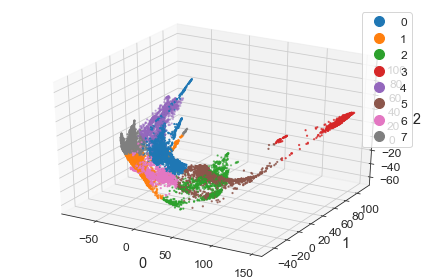

In [69]:
#%matplotlib inline
scprep.plot.scatter3d(data_phate, c = metadata['clusters_for_slingshot'])

### Running Slingshot

Note, running Slingshot on 16,000 cells is not fast. It may take 10 minutes to finish running.

In [21]:
tic = time.time()
results = scprep.run.Slingshot(data_phate, metadata['clusters_for_slingshot'], start_cluster=3, end_cluster=[0, 4, 2] )
print('Ran Slingshot in {:.2f} seconds'.format(time.time() - tic))

R[write to console]: Using full covariance matrix


Ran Slingshot in 531.35 seconds


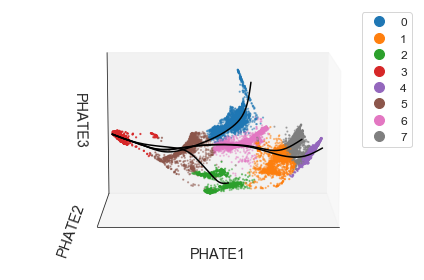

In [62]:
ax = scprep.plot.scatter3d(data_phate, c = metadata['clusters_for_slingshot'], azim=90,elev=10,
                          ticks=None, label_prefix='PHATE')

for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], curve[:,2], c='k')


ax.figure.tight_layout()
ax.figure.savefig('/home/dan/burkhardt/SingleCellWorkshop/lectures/Trajectory_Inference/img/Slingshot.PHATE.png', dpi=300)

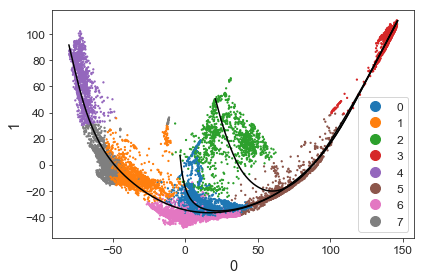

In [40]:
ax = scprep.plot.scatter2d(data_phate, c = metadata['clusters_for_slingshot'])

for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k')

### Running Diffusion Pseudotime

In [26]:
import anndata, scanpy

adata = anndata.AnnData(EBT_counts)

adata.uns['iroot'] = np.argmax(data_phate[0].values)

scanpy.pp.neighbors(adata)
scanpy.tl.diffmap(adata)
scanpy.tl.dpt(adata)

dpt = adata.obs['dpt_pseudotime']

         Falling back to preprocessing with `sc.pp.pca` and default params.


#### Plotting diffusion pseudotime

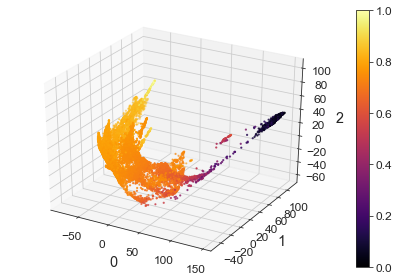

In [27]:
ax = scprep.plot.scatter3d(data_phate, c=dpt)


In [28]:
metadata['dpt'] = dpt

In [32]:
results['pseudotime'].columns = ['slingshot{}'.format(i+1) for i in range(results['pseudotime'].shape[1])]

In [35]:
metadata = pd.concat((metadata, results['pseudotime']), axis=1)

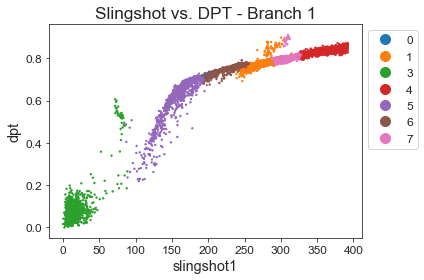

In [37]:
# Get all the cells that are on the desired branch.
curr_branch = 'slingshot1'
mask = ~pd.isnull(metadata[curr_branch])

ax = scprep.plot.scatter(metadata[curr_branch].loc[mask], metadata['dpt'].loc[mask],
                        c=metadata['clusters_for_slingshot'][mask],
                         title='Slingshot vs. DPT - Branch 1',
                        legend_anchor=(1,1))

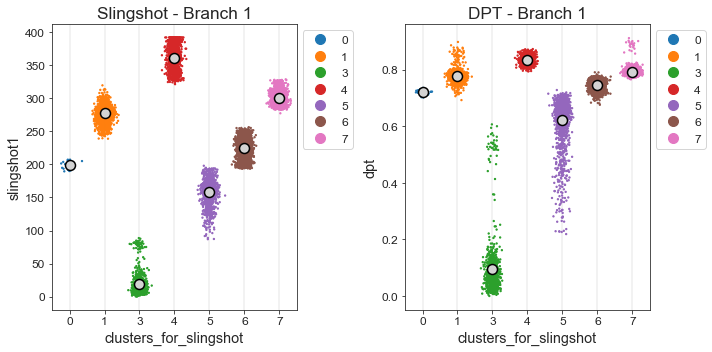

In [82]:
# Get all the cells that are on the desired branch.
curr_branch = '1'

mask = ~pd.isnull(metadata['slingshot{}'.format(curr_branch)])

fig, axes = plt.subplots(1,2, figsize=(10,5))

scprep.plot.jitter(metadata['clusters_for_slingshot'].loc[mask], metadata['slingshot{}'.format(curr_branch)].loc[mask],
                        c=metadata['clusters_for_slingshot'][mask],
                         title='Slingshot - Branch {}'.format(curr_branch),
                        legend_anchor=(1,1), ax=axes[0])

scprep.plot.jitter(metadata['clusters_for_slingshot'].loc[mask], metadata['dpt'].loc[mask],
                        c=metadata['clusters_for_slingshot'][mask],
                         title='DPT - Branch {}'.format(curr_branch),
                        legend_anchor=(1,1), ax=axes[1])

fig.tight_layout()

### Plotting gene expression with pseudotime

Here are a bunch of genes that we selected because they play a role in differentiation in human embryonic stem cells. Plot expression by sample, slingshot ordering, and diffusion pseudotime before and after MAGIC.

Identify one gene that goes up during differentiation, one that goes down, and one that changes non-monotonically.

In [84]:
marker_genes = ['ARID3A (ENSG00000116017)', 'ASCL2 (ENSG00000183734)',  'CD34 (ENSG00000174059)',
 'CDX2 (ENSG00000165556)', 'CER1 (ENSG00000147869)', 'DLX1 (ENSG00000144355)',
 'DMRT3 (ENSG00000064218)', 'EN2 (ENSG00000164778)', 'EOMES (ENSG00000163508)',
 'FOXA2 (ENSG00000125798)', 'FOXD3-AS1 (ENSG00000230798)', 'GATA3-AS1 (ENSG00000197308)',
 'GATA4 (ENSG00000136574)', 'GATA5 (ENSG00000130700)', 'GATA6-AS1 (ENSG00000266010)',
 'GBX2 (ENSG00000168505)', 'GLI3 (ENSG00000106571)', 'HOXA2 (ENSG00000105996)',
 'HOXB1 (ENSG00000120094)', 'HOXB4 (ENSG00000182742)', 'HOXD13 (ENSG00000128714)',
 'HOXD9 (ENSG00000128709)', 'ISL1 (ENSG00000016082)', 'KLF5 (ENSG00000102554)',
 'KLF7 (ENSG00000118263)', 'LEF1 (ENSG00000138795)', 'LHX2 (ENSG00000106689)',
 'LHX5 (ENSG00000089116)', 'LMX1A (ENSG00000162761)', 'MAP2 (ENSG00000078018)',
 'MIXL1 (ENSG00000185155)', 'MYCBP (ENSG00000214114)', 'NANOG (ENSG00000111704)',
 'NES (ENSG00000132688)', 'NKX2-1 (ENSG00000136352)', 'NKX2-5 (ENSG00000183072)',
 'NKX2-8 (ENSG00000136327)', 'NPAS1 (ENSG00000130751)', 'NR2F1-AS1 (ENSG00000237187)',
 'OLIG1 (ENSG00000184221)', 'OLIG3 (ENSG00000177468)', 'ONECUT1 (ENSG00000169856)',
 'ONECUT2 (ENSG00000119547)', 'OTX2 (ENSG00000165588)', 'PAX3 (ENSG00000135903)',
 'PAX6 (ENSG00000007372)', 'PDGFRA (ENSG00000134853)', 'PECAM1 (ENSG00000261371)',
 'POU5F1 (ENSG00000204531)', 'SATB1 (ENSG00000182568)', 'SIX2 (ENSG00000170577)',
 'SIX3-AS1 (ENSG00000236502)', 'SIX6 (ENSG00000184302)', 'SOX13 (ENSG00000143842)',
 'SOX10 (ENSG00000100146)', 'SOX15 (ENSG00000129194)', 'SOX17 (ENSG00000164736)',
 'SOX9 (ENSG00000125398)', 'TTLL10 (ENSG00000162571)', 'TAL1 (ENSG00000162367)',
 'TBX15 (ENSG00000092607)', 'TBX18 (ENSG00000112837)', 'TBX5 (ENSG00000089225)',
 'TNNT2 (ENSG00000118194)', 'WT1 (ENSG00000184937)', 'ZBTB16 (ENSG00000109906)',
 'ZIC2 (ENSG00000043355)', 'ZIC5 (ENSG00000139800)', 'ACTB (ENSG00000075624)',
 'HAND1 (ENSG00000113196)']

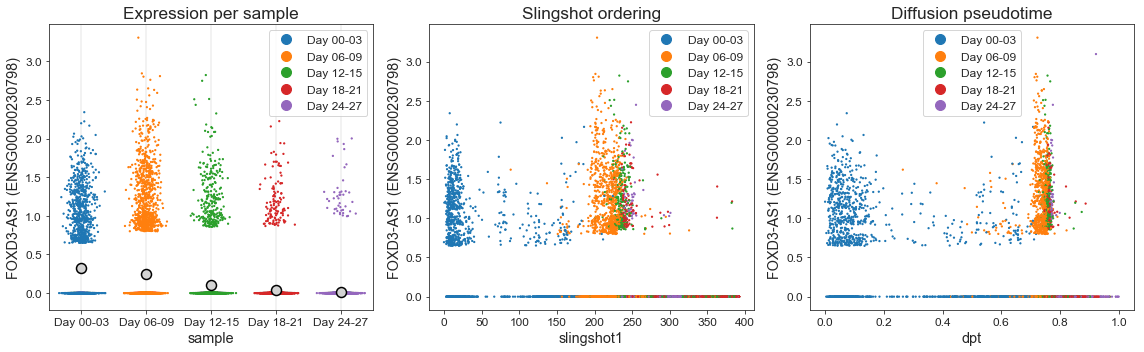

In [99]:
gene = marker_genes[10]

slingshot_branch = 'slingshot1'

fig, axes = plt.subplots(1,3,figsize=(16,5))
scprep.plot.jitter(metadata['sample'], EBT_counts[gene], c=metadata['sample'], 
                   title='Expression per sample',
                   ax=axes[0])
scprep.plot.scatter(metadata[slingshot_branch], EBT_counts[gene], c=metadata['sample'],
                    title='Slingshot ordering',
                    ax=axes[1])
scprep.plot.scatter(metadata['dpt'], EBT_counts[gene], c=metadata['sample'], 
                    title='Diffusion pseudotime',
                    ax=axes[2])

fig.tight_layout()

In [95]:
import magic
data_magic = magic.MAGIC().fit_transform(EBT_counts, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.59 seconds.
    Calculating KNN search...
    Calculated KNN search in 33.99 seconds.
    Calculating affinities...
    Calculated affinities in 14.30 seconds.
  Calculated graph and diffusion operator in 58.14 seconds.
  Calculating imputation...
    Automatically selected t = 10
  Calculated imputation in 2.85 seconds.
Calculated MAGIC in 67.37 seconds.


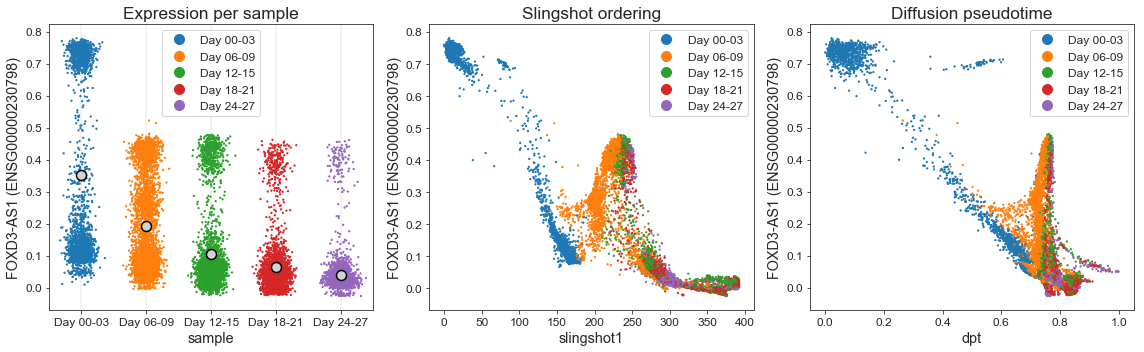

In [97]:
gene = marker_genes[10]

slingshot_branch = 'slingshot1'

fig, axes = plt.subplots(1,3,figsize=(16,5))
scprep.plot.jitter(metadata['sample'], data_magic[gene], c=metadata['sample'], 
                   title='Expression per sample',
                   ax=axes[0])
scprep.plot.scatter(metadata[slingshot_branch], data_magic[gene], c=metadata['sample'],
                    title='Slingshot ordering',
                    ax=axes[1])
scprep.plot.scatter(metadata['dpt'], data_magic[gene], c=metadata['sample'], 
                    title='Diffusion pseudotime',
                    ax=axes[2])

fig.tight_layout()

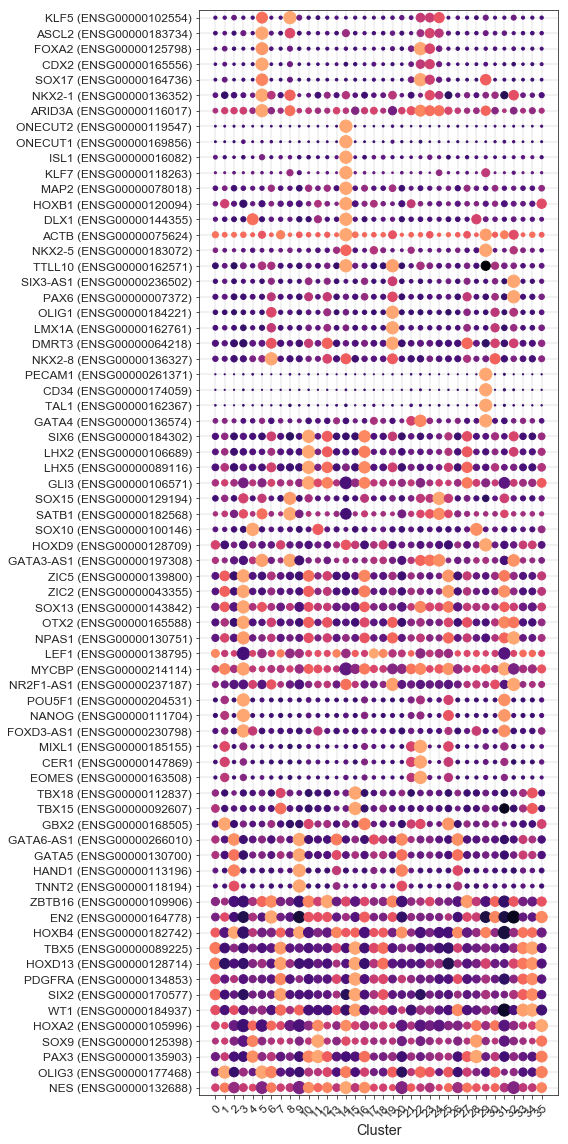

In [44]:
scprep.plot.marker_plot(data_magic, eb_clusters, full_marker_genes, figsize=(12,16), )

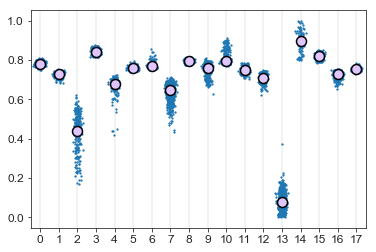

In [31]:
scprep.plot.jitter(clusters, dpt)